#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve,make_scorer
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Анализ и визуализация данных

In [4]:
aim = train['loan_status'] # целевой признак
others = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt'] ]# параметры

In [10]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [7]:
Nan_killer(others, num = 0)

In [8]:
others.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

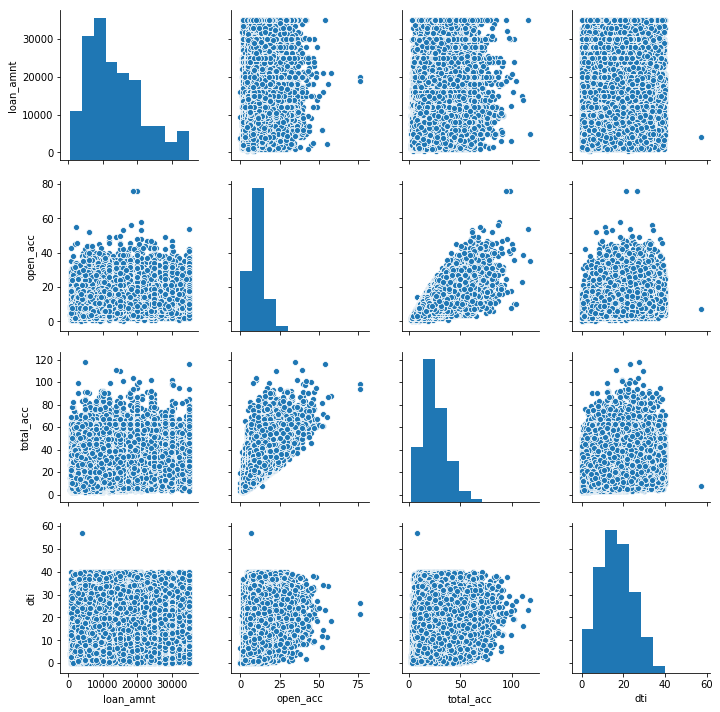

In [9]:
cols = ['loan_amnt',  'open_acc', 'total_acc', 'dti']
sns_plot = sns.pairplot(others[cols])

In [10]:
corr_matrix = others.drop(list(others.columns[others.dtypes == 'object']), axis=1).corr()

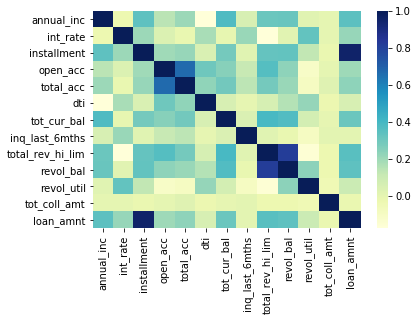

In [11]:
sns.heatmap(corr_matrix,cmap="YlGnBu");

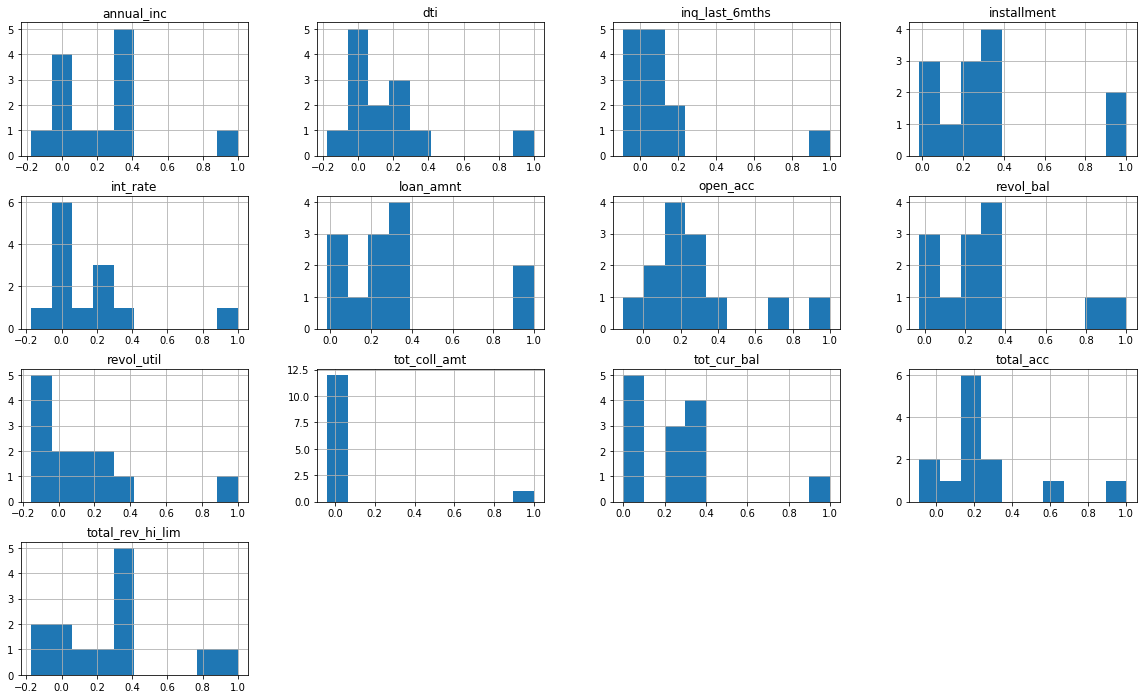

In [12]:
features = others.drop(list(others.columns[others.dtypes == 'object']), axis=1).corr()
features.drop('installment')
features.drop('open_acc')

features.hist(figsize=(20,12));

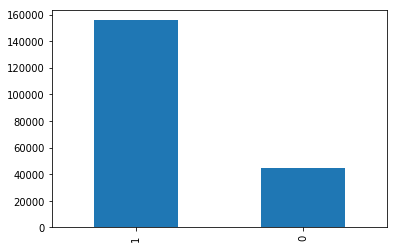

In [13]:
aim.value_counts().plot(kind='bar', label='loan_status')

In [14]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

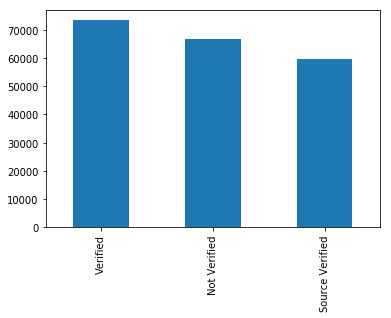

In [50]:
others['verification_status'].value_counts().plot(kind='bar', label='verification_status ')

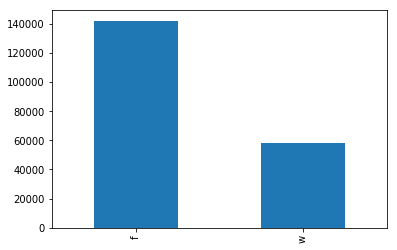

In [51]:
others['initial_list_status'].value_counts().plot(kind='bar', label='initial_list_status')

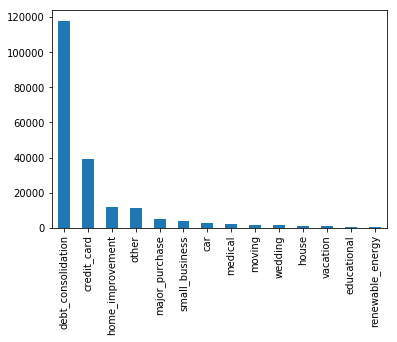

In [52]:
others['purpose'].value_counts().plot(kind='bar', label='purpose')

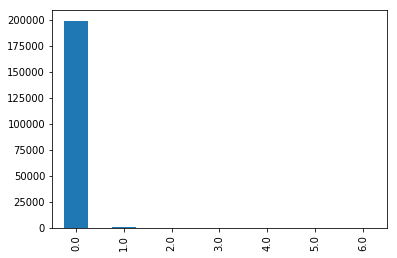

In [16]:
train['collections_12_mths_ex_med'].value_counts().plot(kind='bar', label='purpose')
# skip feature

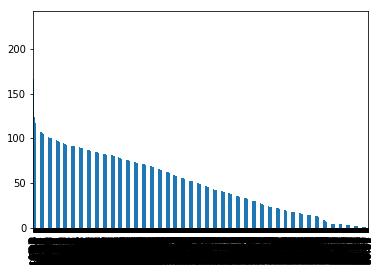

In [17]:
train['dti'].value_counts().plot(kind='bar', label='purpose')


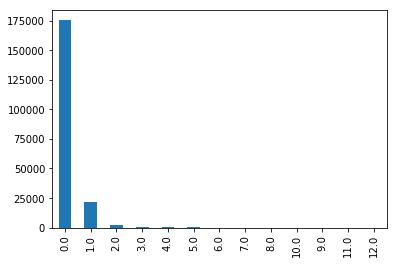

In [18]:
train['pub_rec'].value_counts().plot(kind='bar', label='purpose')
#skip featur

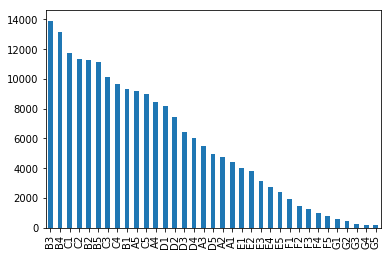

In [15]:
train['sub_grade'].value_counts().plot(kind='bar', label='purpose')


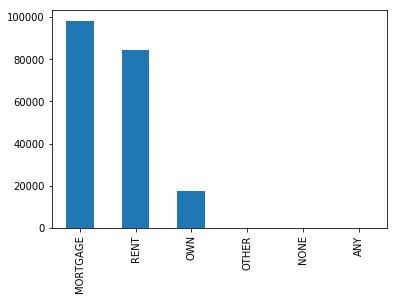

In [16]:
train['home_ownership'].value_counts().plot(kind='bar', label='purpose')

In [22]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

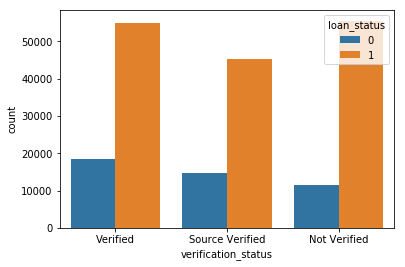

In [30]:
sns.countplot(x='verification_status', hue='loan_status', data=train)
#skip feature

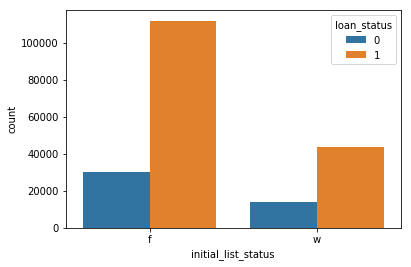

In [27]:
sns.countplot(x='initial_list_status', hue='loan_status', data=train)

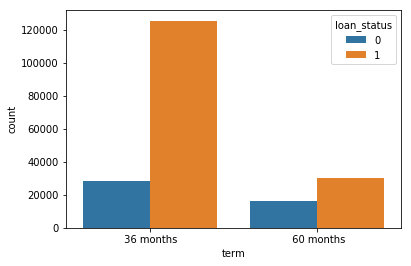

In [28]:
sns.countplot(x='term', hue='loan_status', data=train)

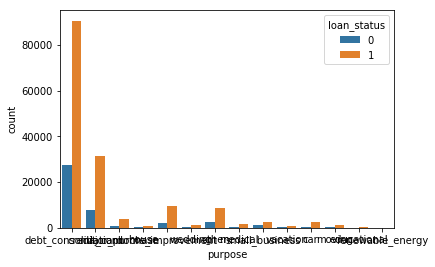

In [29]:
sns.countplot(x='purpose', hue='loan_status', data=train)

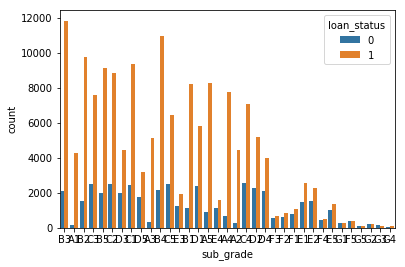

In [47]:
sns.countplot(x='sub_grade', hue='loan_status', data=train)

## PREPROC

In [35]:
def Nan_killer(x, num = -999):
    x['revol_util'] = x['revol_util'].fillna(num)
  #  x['tot_coll_amt'] = x['tot_coll_amt'].fillna(num)
    x['tot_cur_bal'] =  x['tot_cur_bal'].fillna(num)
    # x['total_rev_hi_lim'] =  x['total_rev_hi_lim'].fillna(num)
    

In [34]:
def proc(x,y):
    x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['home_improvement','educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
    x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
    x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership','term'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership','term'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    

    x_test = x_test.reindex(sorted(x_test.columns), axis=1)
    x_train = x_train.reindex(sorted(x_test.columns), axis=1)
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [48]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [49]:
def plot_roc(model, x_test, y_test):  
    pred = model.predict_proba(x_test)
    print("ROC-AUC score: ", roc_auc_score(y_test, pred[:, 1]))
    fpr, tpr,_=roc_curve(y_test,pred[:, 1],drop_intermediate=True)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [38]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [191]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

In [195]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 15 columns):
annual_inc             200189 non-null float64
initial_list_status    200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
grade                  200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_status            200189 non-null int64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(10), int64(1), object(4)
memory usage: 22.9+ MB


In [196]:
x.nunique()

annual_inc             16284
initial_list_status        2
installment            41347
open_acc                  58
total_acc                105
dti                     3975
purpose                   14
grade                      7
home_ownership             6
inq_last_6mths             9
revol_bal              44045
revol_util              1180
loan_status                2
tot_coll_amt            3646
loan_amnt               1317
dtype: int64

In [42]:
x_train, x_test, y_train, y_test = proc(x,y)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null int64
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-nul

In [44]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 43 columns):
acc_now_delinq                60057 non-null float64
annual_inc                    60057 non-null float64
application_type              60057 non-null int64
collections_12_mths_ex_med    60057 non-null float64
dti                           60057 non-null float64
grade_A                       60057 non-null uint8
grade_B                       60057 non-null uint8
grade_C                       60057 non-null uint8
grade_D                       60057 non-null uint8
grade_E                       60057 non-null uint8
grade_F                       60057 non-null uint8
grade_G                       60057 non-null uint8
home_ownership_ANY            60057 non-null int64
home_ownership_MORTGAGE       60057 non-null uint8
home_ownership_NONE           60057 non-null uint8
home_ownership_OTHER          60057 non-null uint8
home_ownership_OWN            60057 non-null uint8
home_ownersh

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, min_samples_leaf = 3).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146765103292894

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9280174951473175

# Бинарная классификация

In [31]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','int_rate','term',
                'total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths',
                 'revol_bal','revol_util','loan_amnt']] 
 # параметры

In [32]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 13 columns):
annual_inc        200189 non-null float64
int_rate          200189 non-null float64
term              200189 non-null object
total_acc         200189 non-null float64
dti               200189 non-null float64
purpose           200189 non-null object
tot_cur_bal       200189 non-null float64
sub_grade         200189 non-null object
home_ownership    200189 non-null object
inq_last_6mths    200189 non-null float64
revol_bal         200189 non-null float64
revol_util        200189 non-null float64
loan_amnt         200189 non-null float64
dtypes: float64(9), object(4)
memory usage: 19.9+ MB


In [36]:
x_train, x_test, y_train, y_test = proc(x,y)

In [37]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
dti                           140132 non-null float64
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null uint8
home_ownership_RENT           140132 non-null uint8
inq_last_6mths                140132 non-null float64
int_rate                      140132 non-null float64
loan_amnt                     140132 non-null float64
purpose_credit_card           140132 non-null uint8
purpose_debt_consolidation    140132 non-null uint8
purpose_other                 140132 non-null uint8
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
sub_grade                     140132 non-null int64
term_ 36 months               140132 non-null uint8
term_ 60 months               140132 n

In [38]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
dti                           140132 non-null float64
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null uint8
home_ownership_RENT           140132 non-null uint8
inq_last_6mths                140132 non-null float64
int_rate                      140132 non-null float64
loan_amnt                     140132 non-null float64
purpose_credit_card           140132 non-null uint8
purpose_debt_consolidation    140132 non-null uint8
purpose_other                 140132 non-null uint8
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
sub_grade                     140132 non-null int64
term_ 36 months               140132 non-null uint8
term_ 60 months               140132 n

## Логистическая регрессия

In [270]:
from sklearn import linear_model

In [271]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.6926848879023262


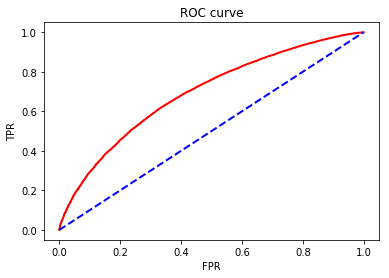

In [272]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [273]:
from sklearn.tree import DecisionTreeClassifier

In [274]:
clf_tree = DecisionTreeClassifier(criterion='entropy',splitter = 'random', max_depth=12, random_state=42, min_samples_leaf = 3)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [275]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.96
Precision score: 0.79
Accuracy score: 0.77


ROC-AUC score:  0.6754340131251977


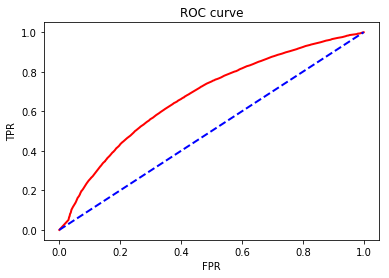

In [276]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [277]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [278]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [12,10,8],
#    'min_samples_leaf': [1,3,5,7],
#    'n_estimators': [80,100,200,500],
#    'criterion' : ['entropy','gini'],
#}
#score = make_scorer(roc_auc_score)
#rf =  RandomForestClassifier(random_state = 42)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 2, scoring=score)
#grid_search.fit(x_train,  y_train)
#grid_search.best_params_
# best_grid = grid_search.best_estimator_

In [279]:
best_grid = RandomForestClassifier(random_state = 42, bootstrap = True, 
                                   max_depth = 12, min_samples_leaf = 1,
                                   n_estimators = 80, criterion = 'entropy')
best_grid.fit(x_train,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [280]:
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7088091643978713


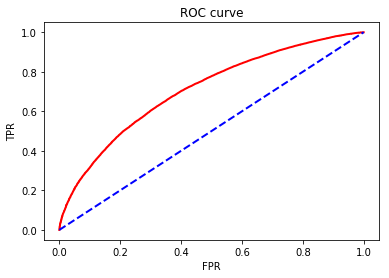

In [281]:
plot_roc(best_grid, x_test, y_test)

## VotingClassifier

In [282]:
from sklearn.ensemble import VotingClassifier

In [283]:
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', best_grid)],voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...mators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [284]:
show_scores(voting_clf, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7062283982087683


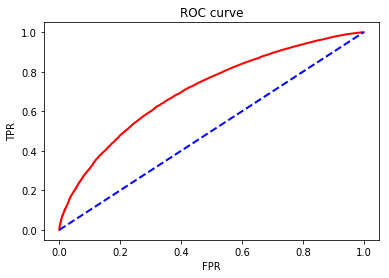

In [285]:
plot_roc(voting_clf, x_test, y_test)

## Xgboost (Grid search)

[Параметры XGBClassifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [39]:
import xgboost as xgb

In [40]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
dti                           140132 non-null float64
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null uint8
home_ownership_RENT           140132 non-null uint8
inq_last_6mths                140132 non-null float64
int_rate                      140132 non-null float64
loan_amnt                     140132 non-null float64
purpose_credit_card           140132 non-null uint8
purpose_debt_consolidation    140132 non-null uint8
purpose_other                 140132 non-null uint8
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
sub_grade                     140132 non-null int64
term_ 36 months               140132 non-null uint8
term_ 60 months               140132 n

In [41]:
xgbst = xgb.XGBClassifier(
                           max_depth=3,
                           min_child_weight=3, #Defines the minimum sum of weights of all observations required
                           gamma = 0.25, 
                                    #A node is split only when the resulting split gives a positive 
                                    #reduction in the loss function. Gamma specifies the minimum loss 
                                    #reduction required to make a split.in a child
                           eval_metric = 'auc',                         
                           subsample= 0.52,
                                    #Denotes the fraction of observations to be randomly sampled for each tree
                           colsample_bytree=0.95, #The number of features to consider while searching for the best split
                           reg_alpha= 5,# L1 regularization term on weights
                           reg_lambda=0,# L2 regularization term on weights.
                           learning_rate = 0.01,
                           n_estimators =4000,
                           objective='binary:logistic',
                           
                           verbosity  = 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
                          
                           scale_pos_weight=1, #Control the balance of positive and negative weights, useful for unbalanced classes
                           seed=20,
                           random_state= 42,
                           missing=None)

In [42]:
xgbst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, eval_metric='auc', gamma=0.25,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=5, reg_lambda=0, scale_pos_weight=1, seed=20, silent=True,
       subsample=0.52, verbosity=2)

In [51]:
show_scores(xgbst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7120131184849037


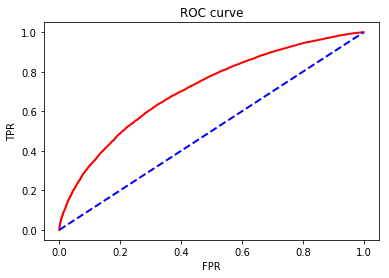

In [53]:
plot_roc(xgbst, x_test, y_test)

## Xgboost (Hypetopt)

In [71]:
from sklearn.metrics import r2_score
from hyperopt import tpe, hp, fmin
import xgboost as xgb
from hyperopt.mongoexp import MongoTrials

In [72]:
def func(args):
    loss = 0
    if args['model'] == xgb.XGBClassifier:
        max_depth = args['param']['max_depth']
        min_child_weight = args['param']['min_child_weight']
        gamma = args['param']['gamma']
        subsample = args['param']['subsample']
        colsample_bytree = args['param']['colsample_bytree']
        reg_alpha = args['param']['reg_alpha']
        clf = xgb.XGBClassifier(eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.1,
                               n_estimators=1000,    
                               reg_lambda=0,
                               max_depth = max_depth,
                               min_child_weight =min_child_weight,
                               gamma =  gamma,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha)
        clf.fit(x_train,y_train)
        y_pred_train = clf.predict_proba(x_train)
        loss =  roc_auc_score(y_train, y_pred_train[:, 1])
        print("Test Score:",clf.score(x_test,y_test))
        print("Train Score:",clf.score(x_train,y_train))
        print("\n=================")
    return -loss


In [73]:
space = hp.choice('classifier',[
        {
        'model': xgb.XGBClassifier,
        'param': {
        'max_depth' : hp.choice('max_depth',range(3,10,2)),
        'min_child_weight' : hp.choice('min_child_weight', range(1,6,2)),
        'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
        'subsample' : hp.choice('subsample', [i/10.0 for i in range(6,10)]),
        'colsample_bytree'  : hp.choice('colsample_bytree', [i/10.0 for i in range(6,10)]),
        'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100])  
        }}
        ])
space

In [76]:
# trials = MongoTrials('mongo://localhost:27017/foo_db/jobs',exp_key='exp1')

In [78]:
# best = fmin(func,space,algo=tpe.suggest,max_evals=100)
best = {'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [79]:
best

{'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [80]:
bst = xgb.XGBClassifier(     eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.01,
                               n_estimators=4000,    
                               reg_lambda=0,
                               seed = 20,
                               max_depth = best['max_depth'],
                               min_child_weight = best['min_child_weight'],
                               gamma =  best['gamma'],
                               subsample = 0.52,
                               colsample_bytree = best['colsample_bytree'],
                               reg_alpha = best['reg_alpha'])

In [81]:
bst.fit(x_train, y_train)

KeyboardInterrupt: 

In [ ]:
show_scores(bst, x_test, y_test)

In [ ]:
plot_roc(bst, x_test, y_test)

## Catboost

In [54]:
from hyperopt import tpe, hp, fmin
import hyperopt 

In [55]:
x['purpose'].value_counts()

debt_consolidation    117953
other                  42899
credit_card            39337
Name: purpose, dtype: int64

In [56]:
x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [57]:
x['purpose'].value_counts()

debt_consolidation    117953
other                  42899
credit_card            39337
Name: purpose, dtype: int64

In [58]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         135
Name: home_ownership, dtype: int64

In [59]:
x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)

In [60]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         135
Name: home_ownership, dtype: int64

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
# x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
# x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
# x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership'])   # OHE (?????)
# x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership'])
#for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
#    if i not in list(x_train):
#        list(my_dataframe)
#        x_test.drop(i, axis=1, inplace=True)
#for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
#    if i not in list(x_test):
#         x_test[i] = 0   

#x_test = x_test.reindex(sorted(x_test.columns), axis=1)
#x_train = x_train.reindex(sorted(x_test.columns), axis=1)

In [62]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 13 columns):
annual_inc        140132 non-null float64
int_rate          140132 non-null float64
term              140132 non-null object
total_acc         140132 non-null float64
dti               140132 non-null float64
purpose           140132 non-null object
tot_cur_bal       140132 non-null float64
sub_grade         140132 non-null int64
home_ownership    140132 non-null object
inq_last_6mths    140132 non-null float64
revol_bal         140132 non-null float64
revol_util        140132 non-null float64
loan_amnt         140132 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 15.0+ MB


In [63]:
x_train.head()

,annual_inc,int_rate,term,total_acc,dti,purpose,tot_cur_bal,sub_grade,home_ownership,inq_last_6mths,revol_bal,revol_util,loan_amnt
193136,75000.0,13.11,36 months,42.0,26.85,credit_card,223010.0,664,MORTGAGE,2.0,38230.0,87.7,20475.0
27784,73000.0,15.99,36 months,38.0,16.47,debt_consolidation,230520.0,682,MORTGAGE,2.0,9874.0,41.0,12000.0
157132,200000.0,8.90,36 months,37.0,13.50,debt_consolidation,488248.0,655,MORTGAGE,2.0,34550.0,63.0,16000.0
81962,100000.0,15.33,36 months,36.0,20.48,debt_consolidation,-999.0,683,MORTGAGE,3.0,88599.0,60.9,12000.0
161,65000.0,14.16,36 months,19.0,14.00,debt_consolidation,18270.0,672,RENT,2.0,10948.0,43.6,10000.0


In [64]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['term', 'purpose', 'home_ownership'], dtype='object')

In [65]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[2, 5, 8]

In [66]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb
import frozendict
# roc_auc_score

In [67]:
params = {'learning_rate': 0.01,
          'depth': 8.0,
       #   'rsm': 0.8789580279825991,
          'l2_leaf_reg': 29.083288170330242,
          'task_type': 'CPU',
          'loss_function': 'Logloss',
          'eval_metric': 'AUC', 'od_type': 'Iter',
          'od_wait': 40,
          'custom_metric': ['AUC'],
          'iterations': 4000,
          'random_seed': 42}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)


In [68]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6803790	best: 0.6803790 (0)	total: 235ms	remaining: 15m 40s
1:	test: 0.6910790	best: 0.6910790 (1)	total: 418ms	remaining: 13m 56s
2:	test: 0.6931592	best: 0.6931592 (2)	total: 602ms	remaining: 13m 21s
3:	test: 0.6938296	best: 0.6938296 (3)	total: 788ms	remaining: 13m 6s
4:	test: 0.6936204	best: 0.6938296 (3)	total: 980ms	remaining: 13m 3s
5:	test: 0.6941532	best: 0.6941532 (5)	total: 1.17s	remaining: 12m 57s
6:	test: 0.6950643	best: 0.6950643 (6)	total: 1.35s	remaining: 12m 50s
7:	test: 0.6956408	best: 0.6956408 (7)	total: 1.53s	remaining: 12m 43s
8:	test: 0.6956057	best: 0.6956408 (7)	total: 1.72s	remaining: 12m 40s
9:	test: 0.6958433	best: 0.6958433 (9)	total: 1.89s	remaining: 12m 34s
10:	test: 0.6963877	best: 0.6963877 (10)	total: 2.08s	remaining: 12m 32s
11:	test: 0.6962129	best: 0.6963877 (10)	total: 2.26s	remaining: 12m 31s
12:	test: 0.6962799	best: 0.6963877 (10)	total: 2.43s	remaining: 12m 25s
13:	test: 0.6965248	best: 0.6965248 (13)	total: 2.6s	remaining: 12m 18s
1

113:	test: 0.7015716	best: 0.7015716 (113)	total: 19.6s	remaining: 11m 8s
114:	test: 0.7016208	best: 0.7016208 (114)	total: 19.8s	remaining: 11m 8s
115:	test: 0.7016688	best: 0.7016688 (115)	total: 20s	remaining: 11m 8s
116:	test: 0.7016594	best: 0.7016688 (115)	total: 20.1s	remaining: 11m 7s
117:	test: 0.7016838	best: 0.7016838 (117)	total: 20.3s	remaining: 11m 6s
118:	test: 0.7017589	best: 0.7017589 (118)	total: 20.4s	remaining: 11m 5s
119:	test: 0.7017361	best: 0.7017589 (118)	total: 20.6s	remaining: 11m 4s
120:	test: 0.7017687	best: 0.7017687 (120)	total: 20.7s	remaining: 11m 4s
121:	test: 0.7018409	best: 0.7018409 (121)	total: 20.9s	remaining: 11m 4s
122:	test: 0.7018292	best: 0.7018409 (121)	total: 21s	remaining: 11m 2s
123:	test: 0.7018002	best: 0.7018409 (121)	total: 21.1s	remaining: 10m 59s
124:	test: 0.7019176	best: 0.7019176 (124)	total: 21.3s	remaining: 10m 58s
125:	test: 0.7018811	best: 0.7019176 (124)	total: 21.4s	remaining: 10m 56s
126:	test: 0.7019081	best: 0.7019176 (1

223:	test: 0.7048247	best: 0.7048247 (223)	total: 38.2s	remaining: 10m 43s
224:	test: 0.7048199	best: 0.7048247 (223)	total: 38.2s	remaining: 10m 41s
225:	test: 0.7048520	best: 0.7048520 (225)	total: 38.4s	remaining: 10m 41s
226:	test: 0.7048874	best: 0.7048874 (226)	total: 38.5s	remaining: 10m 40s
227:	test: 0.7049078	best: 0.7049078 (227)	total: 38.7s	remaining: 10m 39s
228:	test: 0.7049170	best: 0.7049170 (228)	total: 38.8s	remaining: 10m 39s
229:	test: 0.7049581	best: 0.7049581 (229)	total: 39s	remaining: 10m 39s
230:	test: 0.7049873	best: 0.7049873 (230)	total: 39.2s	remaining: 10m 38s
231:	test: 0.7050063	best: 0.7050063 (231)	total: 39.3s	remaining: 10m 38s
232:	test: 0.7050376	best: 0.7050376 (232)	total: 39.5s	remaining: 10m 38s
233:	test: 0.7050608	best: 0.7050608 (233)	total: 39.7s	remaining: 10m 38s
234:	test: 0.7050691	best: 0.7050691 (234)	total: 39.8s	remaining: 10m 38s
235:	test: 0.7050784	best: 0.7050784 (235)	total: 40s	remaining: 10m 37s
236:	test: 0.7051085	best: 0.

333:	test: 0.7070246	best: 0.7070246 (333)	total: 57s	remaining: 10m 25s
334:	test: 0.7070358	best: 0.7070358 (334)	total: 57.2s	remaining: 10m 25s
335:	test: 0.7070338	best: 0.7070358 (334)	total: 57.3s	remaining: 10m 24s
336:	test: 0.7070422	best: 0.7070422 (336)	total: 57.4s	remaining: 10m 24s
337:	test: 0.7070574	best: 0.7070574 (337)	total: 57.6s	remaining: 10m 23s
338:	test: 0.7070706	best: 0.7070706 (338)	total: 57.7s	remaining: 10m 23s
339:	test: 0.7070936	best: 0.7070936 (339)	total: 57.9s	remaining: 10m 23s
340:	test: 0.7070979	best: 0.7070979 (340)	total: 58s	remaining: 10m 22s
341:	test: 0.7071118	best: 0.7071118 (341)	total: 58.2s	remaining: 10m 22s
342:	test: 0.7071272	best: 0.7071272 (342)	total: 58.3s	remaining: 10m 21s
343:	test: 0.7071530	best: 0.7071530 (343)	total: 58.5s	remaining: 10m 21s
344:	test: 0.7071652	best: 0.7071652 (344)	total: 58.6s	remaining: 10m 21s
345:	test: 0.7071844	best: 0.7071844 (345)	total: 58.8s	remaining: 10m 21s
346:	test: 0.7071968	best: 0.

443:	test: 0.7082463	best: 0.7082463 (443)	total: 1m 14s	remaining: 9m 58s
444:	test: 0.7082583	best: 0.7082583 (444)	total: 1m 14s	remaining: 9m 57s
445:	test: 0.7082680	best: 0.7082680 (445)	total: 1m 14s	remaining: 9m 57s
446:	test: 0.7082762	best: 0.7082762 (446)	total: 1m 15s	remaining: 9m 57s
447:	test: 0.7082802	best: 0.7082802 (447)	total: 1m 15s	remaining: 9m 57s
448:	test: 0.7082835	best: 0.7082835 (448)	total: 1m 15s	remaining: 9m 56s
449:	test: 0.7082984	best: 0.7082984 (449)	total: 1m 15s	remaining: 9m 56s
450:	test: 0.7083043	best: 0.7083043 (450)	total: 1m 15s	remaining: 9m 56s
451:	test: 0.7083207	best: 0.7083207 (451)	total: 1m 15s	remaining: 9m 56s
452:	test: 0.7083288	best: 0.7083288 (452)	total: 1m 16s	remaining: 9m 55s
453:	test: 0.7083377	best: 0.7083377 (453)	total: 1m 16s	remaining: 9m 55s
454:	test: 0.7083430	best: 0.7083430 (454)	total: 1m 16s	remaining: 9m 55s
455:	test: 0.7083481	best: 0.7083481 (455)	total: 1m 16s	remaining: 9m 55s
456:	test: 0.7083608	best

553:	test: 0.7090701	best: 0.7090701 (553)	total: 1m 32s	remaining: 9m 32s
554:	test: 0.7090780	best: 0.7090780 (554)	total: 1m 32s	remaining: 9m 32s
555:	test: 0.7090866	best: 0.7090866 (555)	total: 1m 32s	remaining: 9m 31s
556:	test: 0.7090964	best: 0.7090964 (556)	total: 1m 32s	remaining: 9m 31s
557:	test: 0.7091066	best: 0.7091066 (557)	total: 1m 32s	remaining: 9m 31s
558:	test: 0.7091125	best: 0.7091125 (558)	total: 1m 32s	remaining: 9m 31s
559:	test: 0.7091207	best: 0.7091207 (559)	total: 1m 33s	remaining: 9m 31s
560:	test: 0.7091223	best: 0.7091223 (560)	total: 1m 33s	remaining: 9m 31s
561:	test: 0.7091294	best: 0.7091294 (561)	total: 1m 33s	remaining: 9m 31s
562:	test: 0.7091362	best: 0.7091362 (562)	total: 1m 33s	remaining: 9m 30s
563:	test: 0.7091462	best: 0.7091462 (563)	total: 1m 33s	remaining: 9m 30s
564:	test: 0.7091511	best: 0.7091511 (564)	total: 1m 33s	remaining: 9m 30s
565:	test: 0.7091566	best: 0.7091566 (565)	total: 1m 33s	remaining: 9m 30s
566:	test: 0.7091680	best

663:	test: 0.7097397	best: 0.7097397 (663)	total: 1m 49s	remaining: 9m 10s
664:	test: 0.7097460	best: 0.7097460 (664)	total: 1m 49s	remaining: 9m 10s
665:	test: 0.7097530	best: 0.7097530 (665)	total: 1m 49s	remaining: 9m 10s
666:	test: 0.7097546	best: 0.7097546 (666)	total: 1m 50s	remaining: 9m 10s
667:	test: 0.7097576	best: 0.7097576 (667)	total: 1m 50s	remaining: 9m 10s
668:	test: 0.7097617	best: 0.7097617 (668)	total: 1m 50s	remaining: 9m 9s
669:	test: 0.7097702	best: 0.7097702 (669)	total: 1m 50s	remaining: 9m 9s
670:	test: 0.7097768	best: 0.7097768 (670)	total: 1m 50s	remaining: 9m 9s
671:	test: 0.7097796	best: 0.7097796 (671)	total: 1m 50s	remaining: 9m 9s
672:	test: 0.7097799	best: 0.7097799 (672)	total: 1m 51s	remaining: 9m 8s
673:	test: 0.7097852	best: 0.7097852 (673)	total: 1m 51s	remaining: 9m 8s
674:	test: 0.7097924	best: 0.7097924 (674)	total: 1m 51s	remaining: 9m 8s
675:	test: 0.7097961	best: 0.7097961 (675)	total: 1m 51s	remaining: 9m 8s
676:	test: 0.7098002	best: 0.7098

775:	test: 0.7102285	best: 0.7102285 (775)	total: 2m 7s	remaining: 8m 48s
776:	test: 0.7102312	best: 0.7102312 (776)	total: 2m 7s	remaining: 8m 48s
777:	test: 0.7102375	best: 0.7102375 (777)	total: 2m 7s	remaining: 8m 48s
778:	test: 0.7102377	best: 0.7102377 (778)	total: 2m 7s	remaining: 8m 47s
779:	test: 0.7102388	best: 0.7102388 (779)	total: 2m 7s	remaining: 8m 47s
780:	test: 0.7102433	best: 0.7102433 (780)	total: 2m 7s	remaining: 8m 47s
781:	test: 0.7102494	best: 0.7102494 (781)	total: 2m 8s	remaining: 8m 47s
782:	test: 0.7102543	best: 0.7102543 (782)	total: 2m 8s	remaining: 8m 47s
783:	test: 0.7102572	best: 0.7102572 (783)	total: 2m 8s	remaining: 8m 47s
784:	test: 0.7102661	best: 0.7102661 (784)	total: 2m 8s	remaining: 8m 46s
785:	test: 0.7102765	best: 0.7102765 (785)	total: 2m 8s	remaining: 8m 46s
786:	test: 0.7102769	best: 0.7102769 (786)	total: 2m 8s	remaining: 8m 46s
787:	test: 0.7102822	best: 0.7102822 (787)	total: 2m 9s	remaining: 8m 45s
788:	test: 0.7102838	best: 0.7102838 (

885:	test: 0.7105797	best: 0.7105797 (885)	total: 2m 23s	remaining: 8m 25s
886:	test: 0.7105806	best: 0.7105806 (886)	total: 2m 23s	remaining: 8m 25s
887:	test: 0.7105803	best: 0.7105806 (886)	total: 2m 24s	remaining: 8m 25s
888:	test: 0.7105803	best: 0.7105806 (886)	total: 2m 24s	remaining: 8m 24s
889:	test: 0.7105863	best: 0.7105863 (889)	total: 2m 24s	remaining: 8m 24s
890:	test: 0.7105867	best: 0.7105867 (890)	total: 2m 24s	remaining: 8m 24s
891:	test: 0.7105875	best: 0.7105875 (891)	total: 2m 24s	remaining: 8m 24s
892:	test: 0.7105902	best: 0.7105902 (892)	total: 2m 24s	remaining: 8m 24s
893:	test: 0.7105902	best: 0.7105902 (892)	total: 2m 25s	remaining: 8m 23s
894:	test: 0.7105932	best: 0.7105932 (894)	total: 2m 25s	remaining: 8m 23s
895:	test: 0.7105928	best: 0.7105932 (894)	total: 2m 25s	remaining: 8m 23s
896:	test: 0.7105980	best: 0.7105980 (896)	total: 2m 25s	remaining: 8m 23s
897:	test: 0.7106033	best: 0.7106033 (897)	total: 2m 25s	remaining: 8m 23s
898:	test: 0.7106047	best

995:	test: 0.7108597	best: 0.7108602 (994)	total: 2m 40s	remaining: 8m 5s
996:	test: 0.7108611	best: 0.7108611 (996)	total: 2m 40s	remaining: 8m 4s
997:	test: 0.7108661	best: 0.7108661 (997)	total: 2m 41s	remaining: 8m 4s
998:	test: 0.7108683	best: 0.7108683 (998)	total: 2m 41s	remaining: 8m 4s
999:	test: 0.7108768	best: 0.7108768 (999)	total: 2m 41s	remaining: 8m 4s
1000:	test: 0.7108776	best: 0.7108776 (1000)	total: 2m 41s	remaining: 8m 4s
1001:	test: 0.7108818	best: 0.7108818 (1001)	total: 2m 41s	remaining: 8m 4s
1002:	test: 0.7108835	best: 0.7108835 (1002)	total: 2m 41s	remaining: 8m 3s
1003:	test: 0.7108894	best: 0.7108894 (1003)	total: 2m 42s	remaining: 8m 3s
1004:	test: 0.7108906	best: 0.7108906 (1004)	total: 2m 42s	remaining: 8m 3s
1005:	test: 0.7108911	best: 0.7108911 (1005)	total: 2m 42s	remaining: 8m 3s
1006:	test: 0.7108948	best: 0.7108948 (1006)	total: 2m 42s	remaining: 8m 3s
1007:	test: 0.7108953	best: 0.7108953 (1007)	total: 2m 42s	remaining: 8m 3s
1008:	test: 0.7108998	

1103:	test: 0.7111351	best: 0.7111378 (1099)	total: 2m 58s	remaining: 7m 47s
1104:	test: 0.7111344	best: 0.7111378 (1099)	total: 2m 58s	remaining: 7m 46s
1105:	test: 0.7111342	best: 0.7111378 (1099)	total: 2m 58s	remaining: 7m 46s
1106:	test: 0.7111434	best: 0.7111434 (1106)	total: 2m 58s	remaining: 7m 46s
1107:	test: 0.7111440	best: 0.7111440 (1107)	total: 2m 58s	remaining: 7m 46s
1108:	test: 0.7111455	best: 0.7111455 (1108)	total: 2m 58s	remaining: 7m 46s
1109:	test: 0.7111482	best: 0.7111482 (1109)	total: 2m 58s	remaining: 7m 45s
1110:	test: 0.7111516	best: 0.7111516 (1110)	total: 2m 59s	remaining: 7m 45s
1111:	test: 0.7111629	best: 0.7111629 (1111)	total: 2m 59s	remaining: 7m 45s
1112:	test: 0.7111666	best: 0.7111666 (1112)	total: 2m 59s	remaining: 7m 45s
1113:	test: 0.7111743	best: 0.7111743 (1113)	total: 2m 59s	remaining: 7m 45s
1114:	test: 0.7111747	best: 0.7111747 (1114)	total: 2m 59s	remaining: 7m 45s
1115:	test: 0.7111781	best: 0.7111781 (1115)	total: 3m	remaining: 7m 45s
111

1211:	test: 0.7113847	best: 0.7113847 (1211)	total: 3m 15s	remaining: 7m 29s
1212:	test: 0.7113847	best: 0.7113847 (1211)	total: 3m 15s	remaining: 7m 29s
1213:	test: 0.7113870	best: 0.7113870 (1213)	total: 3m 15s	remaining: 7m 29s
1214:	test: 0.7113893	best: 0.7113893 (1214)	total: 3m 16s	remaining: 7m 29s
1215:	test: 0.7113901	best: 0.7113901 (1215)	total: 3m 16s	remaining: 7m 29s
1216:	test: 0.7113928	best: 0.7113928 (1216)	total: 3m 16s	remaining: 7m 29s
1217:	test: 0.7113954	best: 0.7113954 (1217)	total: 3m 16s	remaining: 7m 28s
1218:	test: 0.7113975	best: 0.7113975 (1218)	total: 3m 16s	remaining: 7m 28s
1219:	test: 0.7113960	best: 0.7113975 (1218)	total: 3m 16s	remaining: 7m 28s
1220:	test: 0.7113990	best: 0.7113990 (1220)	total: 3m 17s	remaining: 7m 28s
1221:	test: 0.7114015	best: 0.7114015 (1221)	total: 3m 17s	remaining: 7m 28s
1222:	test: 0.7114018	best: 0.7114018 (1222)	total: 3m 17s	remaining: 7m 28s
1223:	test: 0.7114049	best: 0.7114049 (1223)	total: 3m 17s	remaining: 7m 27s

1318:	test: 0.7115332	best: 0.7115338 (1317)	total: 3m 32s	remaining: 7m 12s
1319:	test: 0.7115362	best: 0.7115362 (1319)	total: 3m 33s	remaining: 7m 12s
1320:	test: 0.7115353	best: 0.7115362 (1319)	total: 3m 33s	remaining: 7m 12s
1321:	test: 0.7115347	best: 0.7115362 (1319)	total: 3m 33s	remaining: 7m 12s
1322:	test: 0.7115351	best: 0.7115362 (1319)	total: 3m 33s	remaining: 7m 12s
1323:	test: 0.7115396	best: 0.7115396 (1323)	total: 3m 33s	remaining: 7m 12s
1324:	test: 0.7115454	best: 0.7115454 (1324)	total: 3m 33s	remaining: 7m 11s
1325:	test: 0.7115442	best: 0.7115454 (1324)	total: 3m 34s	remaining: 7m 11s
1326:	test: 0.7115471	best: 0.7115471 (1326)	total: 3m 34s	remaining: 7m 11s
1327:	test: 0.7115472	best: 0.7115472 (1327)	total: 3m 34s	remaining: 7m 11s
1328:	test: 0.7115475	best: 0.7115475 (1328)	total: 3m 34s	remaining: 7m 11s
1329:	test: 0.7115486	best: 0.7115486 (1329)	total: 3m 34s	remaining: 7m 11s
1330:	test: 0.7115486	best: 0.7115486 (1329)	total: 3m 34s	remaining: 7m 11s

1426:	test: 0.7117360	best: 0.7117371 (1425)	total: 3m 51s	remaining: 6m 56s
1427:	test: 0.7117374	best: 0.7117374 (1427)	total: 3m 51s	remaining: 6m 56s
1428:	test: 0.7117379	best: 0.7117379 (1428)	total: 3m 51s	remaining: 6m 56s
1429:	test: 0.7117332	best: 0.7117379 (1428)	total: 3m 51s	remaining: 6m 56s
1430:	test: 0.7117328	best: 0.7117379 (1428)	total: 3m 51s	remaining: 6m 56s
1431:	test: 0.7117357	best: 0.7117379 (1428)	total: 3m 51s	remaining: 6m 55s
1432:	test: 0.7117361	best: 0.7117379 (1428)	total: 3m 52s	remaining: 6m 55s
1433:	test: 0.7117377	best: 0.7117379 (1428)	total: 3m 52s	remaining: 6m 55s
1434:	test: 0.7117398	best: 0.7117398 (1434)	total: 3m 52s	remaining: 6m 55s
1435:	test: 0.7117389	best: 0.7117398 (1434)	total: 3m 52s	remaining: 6m 55s
1436:	test: 0.7117405	best: 0.7117405 (1436)	total: 3m 52s	remaining: 6m 55s
1437:	test: 0.7117438	best: 0.7117438 (1437)	total: 3m 52s	remaining: 6m 55s
1438:	test: 0.7117470	best: 0.7117470 (1438)	total: 3m 53s	remaining: 6m 54s

1534:	test: 0.7118692	best: 0.7118724 (1529)	total: 4m 8s	remaining: 6m 39s
1535:	test: 0.7118712	best: 0.7118724 (1529)	total: 4m 8s	remaining: 6m 39s
1536:	test: 0.7118719	best: 0.7118724 (1529)	total: 4m 9s	remaining: 6m 39s
1537:	test: 0.7118775	best: 0.7118775 (1537)	total: 4m 9s	remaining: 6m 39s
1538:	test: 0.7118814	best: 0.7118814 (1538)	total: 4m 9s	remaining: 6m 38s
1539:	test: 0.7118813	best: 0.7118814 (1538)	total: 4m 9s	remaining: 6m 38s
1540:	test: 0.7118812	best: 0.7118814 (1538)	total: 4m 9s	remaining: 6m 38s
1541:	test: 0.7118876	best: 0.7118876 (1541)	total: 4m 9s	remaining: 6m 38s
1542:	test: 0.7118914	best: 0.7118914 (1542)	total: 4m 10s	remaining: 6m 38s
1543:	test: 0.7118937	best: 0.7118937 (1543)	total: 4m 10s	remaining: 6m 38s
1544:	test: 0.7118947	best: 0.7118947 (1544)	total: 4m 10s	remaining: 6m 37s
1545:	test: 0.7118931	best: 0.7118947 (1544)	total: 4m 10s	remaining: 6m 37s
1546:	test: 0.7118934	best: 0.7118947 (1544)	total: 4m 10s	remaining: 6m 37s
1547:	t

1641:	test: 0.7120229	best: 0.7120229 (1641)	total: 4m 26s	remaining: 6m 22s
1642:	test: 0.7120235	best: 0.7120235 (1642)	total: 4m 26s	remaining: 6m 22s
1643:	test: 0.7120251	best: 0.7120251 (1643)	total: 4m 26s	remaining: 6m 22s
1644:	test: 0.7120259	best: 0.7120259 (1644)	total: 4m 27s	remaining: 6m 22s
1645:	test: 0.7120275	best: 0.7120275 (1645)	total: 4m 27s	remaining: 6m 22s
1646:	test: 0.7120278	best: 0.7120278 (1646)	total: 4m 27s	remaining: 6m 22s
1647:	test: 0.7120322	best: 0.7120322 (1647)	total: 4m 27s	remaining: 6m 21s
1648:	test: 0.7120338	best: 0.7120338 (1648)	total: 4m 27s	remaining: 6m 21s
1649:	test: 0.7120360	best: 0.7120360 (1649)	total: 4m 27s	remaining: 6m 21s
1650:	test: 0.7120359	best: 0.7120360 (1649)	total: 4m 28s	remaining: 6m 21s
1651:	test: 0.7120383	best: 0.7120383 (1651)	total: 4m 28s	remaining: 6m 21s
1652:	test: 0.7120415	best: 0.7120415 (1652)	total: 4m 28s	remaining: 6m 21s
1653:	test: 0.7120418	best: 0.7120418 (1653)	total: 4m 28s	remaining: 6m 20s

1748:	test: 0.7121167	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 5s
1749:	test: 0.7121139	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 5s
1750:	test: 0.7121135	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 5s
1751:	test: 0.7121110	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 4s
1752:	test: 0.7121133	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 4s
1753:	test: 0.7121104	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 4s
1754:	test: 0.7121102	best: 0.7121167 (1748)	total: 4m 44s	remaining: 6m 4s
1755:	test: 0.7121105	best: 0.7121167 (1748)	total: 4m 45s	remaining: 6m 4s
1756:	test: 0.7121109	best: 0.7121167 (1748)	total: 4m 45s	remaining: 6m 4s
1757:	test: 0.7121096	best: 0.7121167 (1748)	total: 4m 45s	remaining: 6m 4s
1758:	test: 0.7121124	best: 0.7121167 (1748)	total: 4m 45s	remaining: 6m 3s
1759:	test: 0.7121125	best: 0.7121167 (1748)	total: 4m 45s	remaining: 6m 3s
1760:	test: 0.7121177	best: 0.7121177 (1760)	total: 4m 45s	remaining: 6m 3s
1761:	test: 

1856:	test: 0.7121409	best: 0.7121523 (1842)	total: 5m 2s	remaining: 5m 48s
1857:	test: 0.7121405	best: 0.7121523 (1842)	total: 5m 2s	remaining: 5m 48s
1858:	test: 0.7121454	best: 0.7121523 (1842)	total: 5m 2s	remaining: 5m 48s
1859:	test: 0.7121423	best: 0.7121523 (1842)	total: 5m 2s	remaining: 5m 48s
1860:	test: 0.7121401	best: 0.7121523 (1842)	total: 5m 2s	remaining: 5m 48s
1861:	test: 0.7121404	best: 0.7121523 (1842)	total: 5m 2s	remaining: 5m 47s
1862:	test: 0.7121429	best: 0.7121523 (1842)	total: 5m 3s	remaining: 5m 47s
1863:	test: 0.7121429	best: 0.7121523 (1842)	total: 5m 3s	remaining: 5m 47s
1864:	test: 0.7121466	best: 0.7121523 (1842)	total: 5m 3s	remaining: 5m 47s
1865:	test: 0.7121473	best: 0.7121523 (1842)	total: 5m 3s	remaining: 5m 47s
1866:	test: 0.7121481	best: 0.7121523 (1842)	total: 5m 3s	remaining: 5m 47s
1867:	test: 0.7121442	best: 0.7121523 (1842)	total: 5m 4s	remaining: 5m 47s
1868:	test: 0.7121456	best: 0.7121523 (1842)	total: 5m 4s	remaining: 5m 46s
1869:	test: 

1963:	test: 0.7121966	best: 0.7121966 (1963)	total: 5m 20s	remaining: 5m 32s
1964:	test: 0.7121976	best: 0.7121976 (1964)	total: 5m 20s	remaining: 5m 32s
1965:	test: 0.7121988	best: 0.7121988 (1965)	total: 5m 20s	remaining: 5m 32s
1966:	test: 0.7122049	best: 0.7122049 (1966)	total: 5m 21s	remaining: 5m 31s
1967:	test: 0.7122022	best: 0.7122049 (1966)	total: 5m 21s	remaining: 5m 31s
1968:	test: 0.7122017	best: 0.7122049 (1966)	total: 5m 21s	remaining: 5m 31s
1969:	test: 0.7122012	best: 0.7122049 (1966)	total: 5m 21s	remaining: 5m 31s
1970:	test: 0.7122004	best: 0.7122049 (1966)	total: 5m 21s	remaining: 5m 31s
1971:	test: 0.7122017	best: 0.7122049 (1966)	total: 5m 21s	remaining: 5m 31s
1972:	test: 0.7121993	best: 0.7122049 (1966)	total: 5m 22s	remaining: 5m 30s
1973:	test: 0.7122036	best: 0.7122049 (1966)	total: 5m 22s	remaining: 5m 30s
1974:	test: 0.7122049	best: 0.7122049 (1974)	total: 5m 22s	remaining: 5m 30s
1975:	test: 0.7122068	best: 0.7122068 (1975)	total: 5m 22s	remaining: 5m 30s

2070:	test: 0.7122690	best: 0.7122730 (2056)	total: 5m 38s	remaining: 5m 15s
2071:	test: 0.7122702	best: 0.7122730 (2056)	total: 5m 38s	remaining: 5m 15s
2072:	test: 0.7122738	best: 0.7122738 (2072)	total: 5m 38s	remaining: 5m 15s
2073:	test: 0.7122759	best: 0.7122759 (2073)	total: 5m 39s	remaining: 5m 14s
2074:	test: 0.7122754	best: 0.7122759 (2073)	total: 5m 39s	remaining: 5m 14s
2075:	test: 0.7122751	best: 0.7122759 (2073)	total: 5m 39s	remaining: 5m 14s
2076:	test: 0.7122770	best: 0.7122770 (2076)	total: 5m 39s	remaining: 5m 14s
2077:	test: 0.7122784	best: 0.7122784 (2077)	total: 5m 39s	remaining: 5m 14s
2078:	test: 0.7122777	best: 0.7122784 (2077)	total: 5m 39s	remaining: 5m 14s
2079:	test: 0.7122785	best: 0.7122785 (2079)	total: 5m 40s	remaining: 5m 13s
2080:	test: 0.7122786	best: 0.7122786 (2080)	total: 5m 40s	remaining: 5m 13s
2081:	test: 0.7122804	best: 0.7122804 (2081)	total: 5m 40s	remaining: 5m 13s
2082:	test: 0.7122808	best: 0.7122808 (2082)	total: 5m 40s	remaining: 5m 13s

2178:	test: 0.7123195	best: 0.7123309 (2167)	total: 5m 56s	remaining: 4m 57s
2179:	test: 0.7123216	best: 0.7123309 (2167)	total: 5m 56s	remaining: 4m 57s
2180:	test: 0.7123202	best: 0.7123309 (2167)	total: 5m 56s	remaining: 4m 57s
2181:	test: 0.7123176	best: 0.7123309 (2167)	total: 5m 56s	remaining: 4m 57s
2182:	test: 0.7123161	best: 0.7123309 (2167)	total: 5m 57s	remaining: 4m 57s
2183:	test: 0.7123158	best: 0.7123309 (2167)	total: 5m 57s	remaining: 4m 57s
2184:	test: 0.7123170	best: 0.7123309 (2167)	total: 5m 57s	remaining: 4m 56s
2185:	test: 0.7123217	best: 0.7123309 (2167)	total: 5m 57s	remaining: 4m 56s
2186:	test: 0.7123231	best: 0.7123309 (2167)	total: 5m 57s	remaining: 4m 56s
2187:	test: 0.7123232	best: 0.7123309 (2167)	total: 5m 57s	remaining: 4m 56s
2188:	test: 0.7123220	best: 0.7123309 (2167)	total: 5m 58s	remaining: 4m 56s
2189:	test: 0.7123232	best: 0.7123309 (2167)	total: 5m 58s	remaining: 4m 56s
2190:	test: 0.7123236	best: 0.7123309 (2167)	total: 5m 58s	remaining: 4m 55s

2286:	test: 0.7123507	best: 0.7123531 (2277)	total: 6m 13s	remaining: 4m 40s
2287:	test: 0.7123529	best: 0.7123531 (2277)	total: 6m 14s	remaining: 4m 39s
2288:	test: 0.7123549	best: 0.7123549 (2288)	total: 6m 14s	remaining: 4m 39s
2289:	test: 0.7123552	best: 0.7123552 (2289)	total: 6m 14s	remaining: 4m 39s
2290:	test: 0.7123555	best: 0.7123555 (2290)	total: 6m 14s	remaining: 4m 39s
2291:	test: 0.7123549	best: 0.7123555 (2290)	total: 6m 14s	remaining: 4m 39s
2292:	test: 0.7123563	best: 0.7123563 (2292)	total: 6m 14s	remaining: 4m 39s
2293:	test: 0.7123560	best: 0.7123563 (2292)	total: 6m 15s	remaining: 4m 38s
2294:	test: 0.7123531	best: 0.7123563 (2292)	total: 6m 15s	remaining: 4m 38s
2295:	test: 0.7123537	best: 0.7123563 (2292)	total: 6m 15s	remaining: 4m 38s
2296:	test: 0.7123553	best: 0.7123563 (2292)	total: 6m 15s	remaining: 4m 38s
2297:	test: 0.7123565	best: 0.7123565 (2297)	total: 6m 15s	remaining: 4m 38s
2298:	test: 0.7123559	best: 0.7123565 (2297)	total: 6m 15s	remaining: 4m 38s

2393:	test: 0.7124006	best: 0.7124062 (2381)	total: 6m 31s	remaining: 4m 22s
2394:	test: 0.7124006	best: 0.7124062 (2381)	total: 6m 31s	remaining: 4m 22s
2395:	test: 0.7123995	best: 0.7124062 (2381)	total: 6m 31s	remaining: 4m 22s
2396:	test: 0.7123985	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 22s
2397:	test: 0.7124003	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 22s
2398:	test: 0.7124028	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 21s
2399:	test: 0.7123999	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 21s
2400:	test: 0.7124014	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 21s
2401:	test: 0.7124024	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 21s
2402:	test: 0.7124007	best: 0.7124062 (2381)	total: 6m 32s	remaining: 4m 21s
2403:	test: 0.7123983	best: 0.7124062 (2381)	total: 6m 33s	remaining: 4m 21s
2404:	test: 0.7124015	best: 0.7124062 (2381)	total: 6m 33s	remaining: 4m 20s
2405:	test: 0.7124018	best: 0.7124062 (2381)	total: 6m 33s	remaining: 4m 20s

In [69]:
show_scores(best_model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7124156643138975


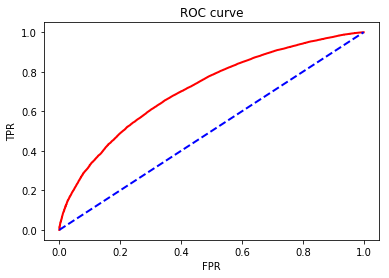

In [70]:
plot_roc(best_model, x_test, y_test)

In [71]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

int_rate: 12.498241102001167
sub_grade: 12.102954746680242
annual_inc: 11.76001523433429
tot_cur_bal: 9.68309766647899
dti: 9.230189463053092
loan_amnt: 9.105722604022958
revol_util: 7.7378536421712525
revol_bal: 6.96286331945209
total_acc: 5.761766809305769
term: 4.905275803738784
purpose: 3.6421169752404894
home_ownership: 3.3469234258517067
inq_last_6mths: 3.2629792076691717


In [72]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

In [73]:
const_params = frozendict.frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'od_type': 'Iter',
    'od_wait': 40,
    'custom_metric': ['AUC'],
    'iterations': 400,
    'random_seed':42})

In [74]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'rsm' :  hyper_params['rsm'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}

    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()        
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=42,
            verbose=False)
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [75]:

def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'depth': hp.quniform("depth", 4, 10, 1),
        'rsm': hp.uniform ('rsm', 0.75, 1.0),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 100)}
 
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=42))
    return best

def train_best_model(dataset, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization  
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params



In [ ]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.8661056258519679, 'depth': 6.0, 'rsm': 0.863675263055343, 'l2_leaf_reg': 6.914443573951684, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
  0%|                                                                             | 0/50 [00:00<?, ?it/s, best loss: ?]

In [ ]:
params

In [ ]:
plot_roc(model, x_test, y_test)

In [ ]:
show_scores(model, x_test, y_test)

## LightGBM

In [33]:
import lightgbm as lgb

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
categorical_columns = x.columns[x.dtypes == 'object']
categorical_columns

Index(['initial_list_status', 'purpose', 'grade', 'home_ownership',
       'application_type'],
      dtype='object')

In [154]:
x_train['purpose'].value_counts()

debt_consolidation    82494
credit_card           27517
home_improvement       8322
other                  7876
major_purchase         3443
small_business         2665
car                    1964
medical                1589
moving                 1163
wedding                1028
house                   895
vacation                856
educational             182
renewable_energy        138
Name: purpose, dtype: int64

In [140]:
x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
categorical_columns = x.columns[x.dtypes == 'object']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null bool
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
purpose                       140132 non-null object
grade                         140132 non-null object
home_ownership                140132 non-null object
inq_last_6mths                140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                 

In [127]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 20,
    'max_depth' : 6,
    'max_bin':100,
    'learning_rate':  0.35,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1' : 32,
    'verbose': 0}

In [128]:
params

{'boosting_type': 'dart',
 'objective': 'binary',
 'metric': {'auc'},
 'num_leaves': 20,
 'max_depth': 6,
 'max_bin': 100,
 'learning_rate': 0.35,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'lambda_l1': 32,
 'verbose': 0}

In [129]:
x_train.head()

,acc_now_delinq,annual_inc,application_type,collections_12_mths_ex_med,dti,grade_A,grade_B,grade_C,grade_D,grade_E,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,revol_bal,revol_util,tot_coll_amt,total_acc
193136,0.0,75000.0,True,0.0,26.85,0,1,0,0,0,...,0,0,0,0,0,0,38230.0,87.7,0.0,42.0
27784,0.0,73000.0,True,0.0,16.47,0,0,0,1,0,...,0,0,0,0,0,0,9874.0,41.0,0.0,38.0
157132,0.0,200000.0,True,0.0,13.50,1,0,0,0,0,...,0,0,0,0,0,0,34550.0,63.0,0.0,37.0
81962,0.0,100000.0,True,0.0,20.48,0,0,0,1,0,...,0,0,0,0,0,0,88599.0,60.9,0.0,36.0
161,0.0,65000.0,True,0.0,14.00,0,0,1,0,0,...,0,0,0,0,0,0,10948.0,43.6,0.0,19.0


In [130]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [131]:
evals_result = {}

In [132]:
num_train, num_feature = x_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

In [133]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=[lgb_train, lgb_eval],
               # feature_name=feature_name,              
              #  categorical_feature= categorical_features_indices,
             #   learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's auc: 0.720699	valid_1's auc: 0.708299
[200]	training's auc: 0.726036	valid_1's auc: 0.709584
[300]	training's auc: 0.730732	valid_1's auc: 0.710076
[400]	training's auc: 0.734714	valid_1's auc: 0.71066
[500]	training's auc: 0.738471	valid_1's auc: 0.710405
[600]	training's auc: 0.739775	valid_1's auc: 0.710752
[700]	training's auc: 0.742352	valid_1's auc: 0.711178
[800]	training's auc: 0.744439	valid_1's auc: 0.710858
[900]	training's auc: 0.746693	valid_1's auc: 0.710874
[1000]	training's auc: 0.748546	valid_1's auc: 0.710658
[1100]	training's auc: 0.750315	valid_1's auc: 0.709928
[1200]	training's auc: 0.751638	valid_1's auc: 0.709708
[1300]	training's auc: 0.75301	valid_1's auc: 0.709218
[1400]	training's auc: 0.755273	valid_1's auc: 0.708481
[1500]	training's auc: 0.756091	valid_1's auc: 0.708636
[1600]	training's auc: 0.757775	valid_1's auc: 0.708289
[1700]	training's auc: 0.759684	valid_1's auc: 0.708028
[1800]	training's auc: 0.761302	valid_1's auc: 0.707554
[19

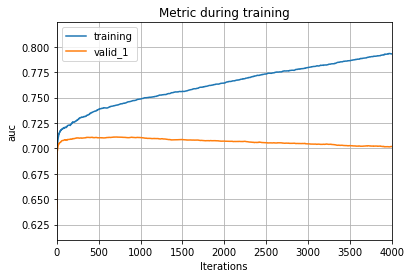

In [134]:
lgb.plot_metric(evals_result, metric='auc')
plt.show()